# Web Scraping + Image Processing 

In [ ]:
import pandas as pd
import requests 
from bs4 import BeautifulSoup 
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Scrape an RGB image from a target webpage

In [2]:
base_url = "https://www.scrapethissite.com"
outer_url = base_url + "/pages/frames/"

**Load the outer page**

In [3]:
response = requests.get(outer_url)
soup = BeautifulSoup(response.content, "html.parser")

**Find the iframe src**

In [4]:
iframe = soup.find("iframe")
if iframe is None:
    raise ValueError("No iframe found on the page.")

iframe_src = iframe['src']
iframe_url = base_url + iframe_src

**load the iframe content**

In [ ]:
iframe_response = requests.get(iframe_url)
iframe_soup = BeautifulSoup(iframe_response.content, "html.parser")

**Load and show the external turtle image**

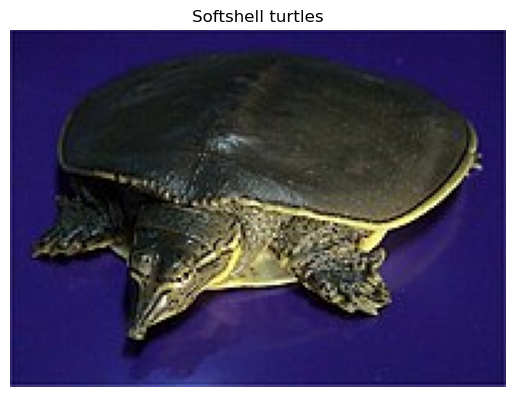

In [16]:
img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Apalone_spinifera.jpg/200px-Apalone_spinifera.jpg"
img_response = requests.get(img_url)

if img_response.status_code == 200:
    image_array = np.asarray(bytearray(img_response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    cv2.imwrite("Apalone_spinifera.jpg", image)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("Softshell turtles")
    plt.show()
else:
    print("Failed to download turtle image.")

## 2. Apply Advanced Histogram Analysis
Red, Green, and Blue channels with combined normalized histogram.

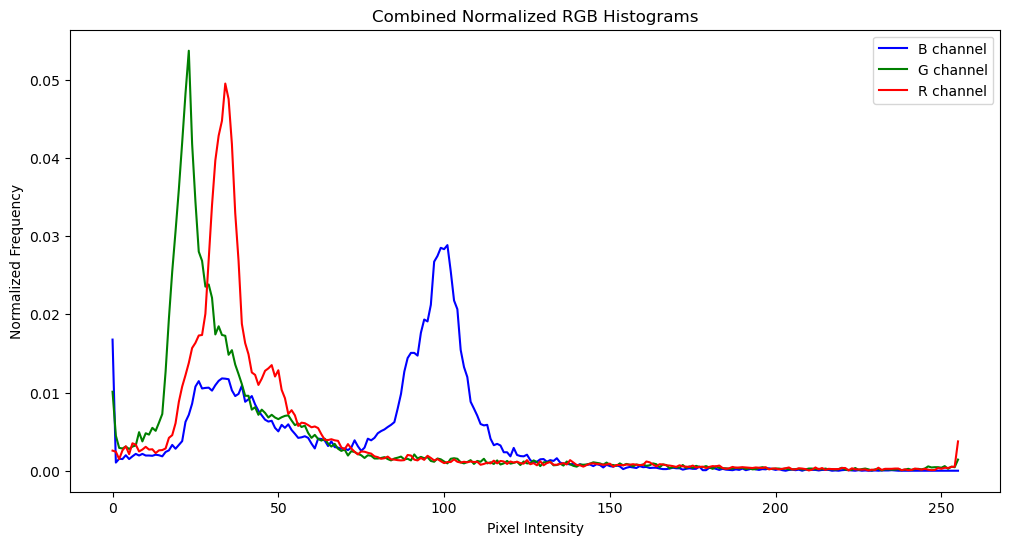

In [31]:
def rgb_histograms(image):
    colors = ('b', 'g', 'r')
    plt.figure(figsize=(12,6))
    
    # Individual RGB histograms
    for i, col in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0,256])
        hist = hist / hist.sum()  # Normalize
        plt.plot(hist, color=col, label=f'{col.upper()} channel')

    plt.title('Combined Normalized RGB Histograms')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.show()
    
rgb_histograms(image)

## 3. Perform Multiple Intensity Transformations
### 3.1 Logarithmic Transformation for contrast enhancement in dark regions.

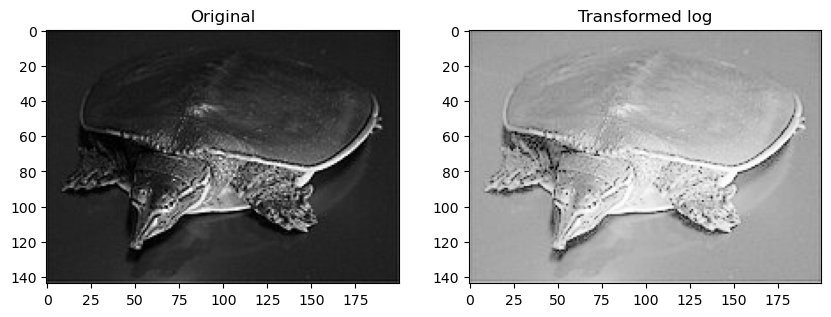

In [33]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
def log_transform(image):
    c = 255 / np.log(1 + np.max(image))
    log_image = c * np.log(1 + image.astype(np.float32))
    return np.uint8(np.clip(log_image, 0, 255))

image_log = log_transform(gray_image)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_image, cmap='gray')
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(image_log, cmap='gray')
plt.title("Transformed log")
plt.show()

### 3.2 Gamma Correction with at least two different gamma values. 
#### (γ = 0.8 and γ = 3.0)

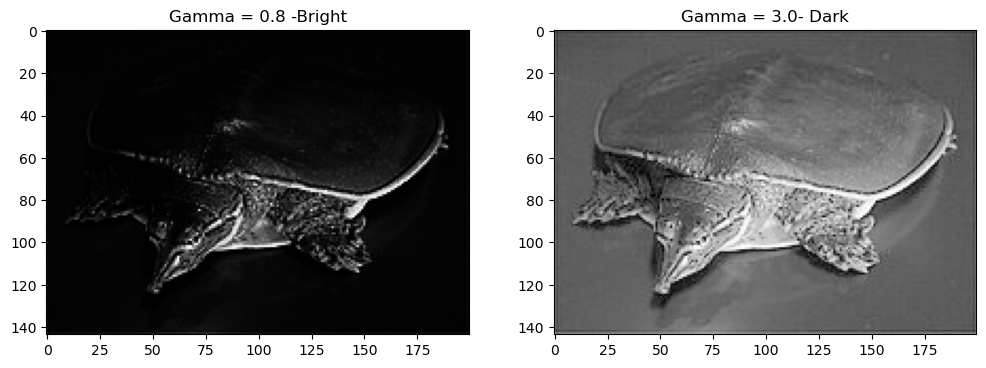

In [41]:
def gamma_correction(image, gamma):
    inverse_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inverse_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

gamma_image1 = gamma_correction(gray_image, 0.8)
gamma_image2 = gamma_correction(gray_image, 3.0)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(gamma_img1, cmap='gray')
plt.title("Gamma = 0.8 -Bright")

plt.subplot(1,2,2)
plt.imshow(gamma_img2, cmap='gray')
plt.title("Gamma = 3.0- Dark")
plt.show()

### 3.3 Contrast Stretching with defined min/max intensity values.

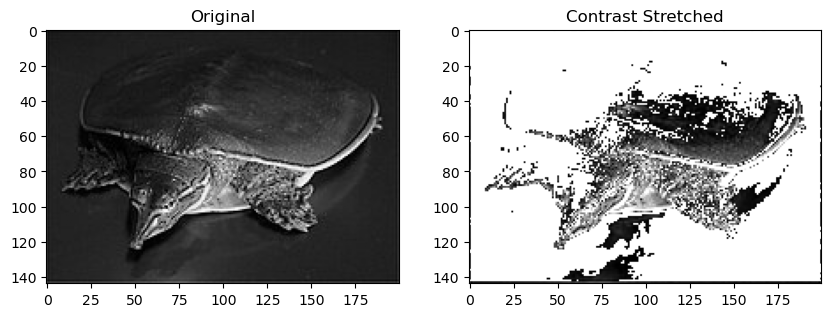

In [42]:
def contrast_stretch(image, min_in=50, max_in=200):
    stretched = np.clip((image - min_in) * (255 / (max_in - min_in)), 0, 255)
    return stretched.astype(np.uint8)

stretched_image = contrast_stretch(gray_image)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_image, cmap='gray')
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(stretched_image, cmap='gray')
plt.title("Contrast Stretched")
plt.show()


## 4. Apply Histogram Equalization

### 4.1 Equalize each RGB channel separately.

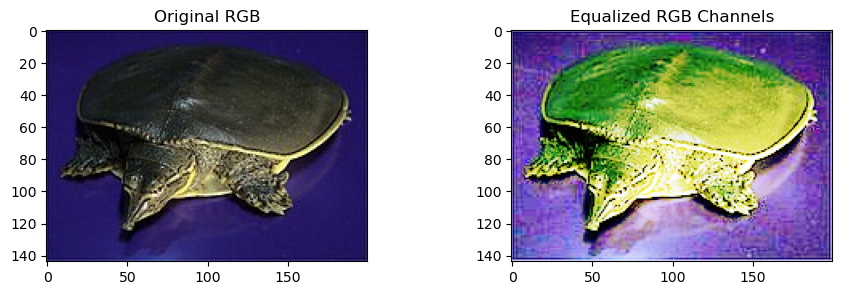

In [52]:
def RGB_Channel_Equalization(image):
    b, g, r = cv2.split(image)
    eq_b = cv2.equalizeHist(b)
    eq_g = cv2.equalizeHist(g)
    eq_r = cv2.equalizeHist(r)
    return cv2.merge((eq_b, eq_g, eq_r))

equalize_rgb = RGB_Channel_Equalization(image)

plt.figure(figsize=(11,3))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original RGB")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(equalize_rgb, cv2.COLOR_BGR2RGB))
plt.title("Equalized RGB Channels")
plt.show()

### 4.2 Equalize the luminance channel in YCrCb or LAB space while preserving colors.

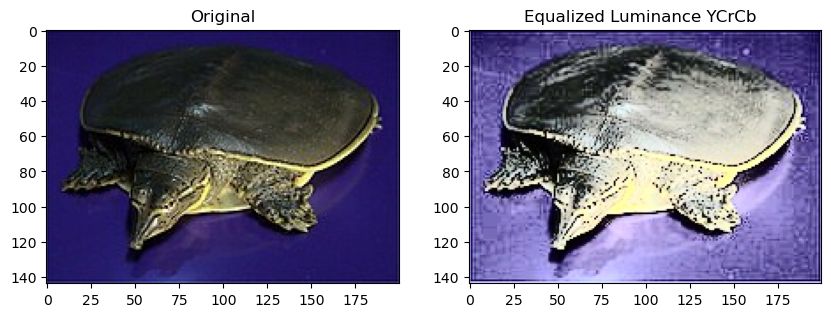

In [51]:
def equalize_luminance_ycrcb(image):
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    ycrcb_eq = cv2.merge((y_eq, cr, cb))
    return cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

equalize_ycrcb = equalize_luminance_ycrcb(image)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(equalize_ycrcb, cv2.COLOR_BGR2RGB))
plt.title("Equalized Luminance YCrCb  ")
plt.show()

## 5. Thresholding and Segmentation

### 5.1 Convert to grayscale and apply Otsu’s thresholding.

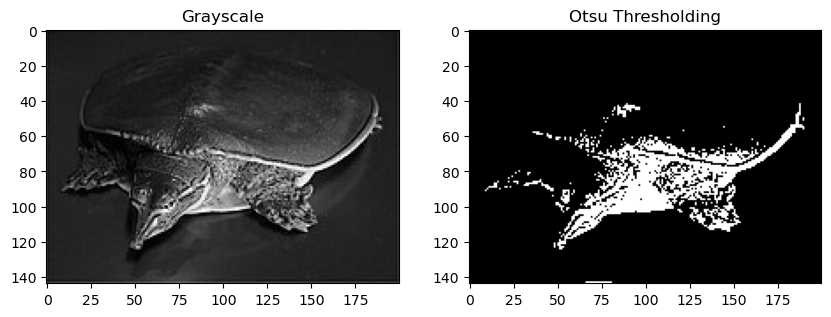

In [47]:
_, otsu_threshold = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale")

plt.subplot(1,2,2)
plt.imshow(otsu_threshold, cmap='gray')
plt.title("Otsu Thresholding")
plt.show()

### 5.2 Apply adaptive thresholding and compare results.

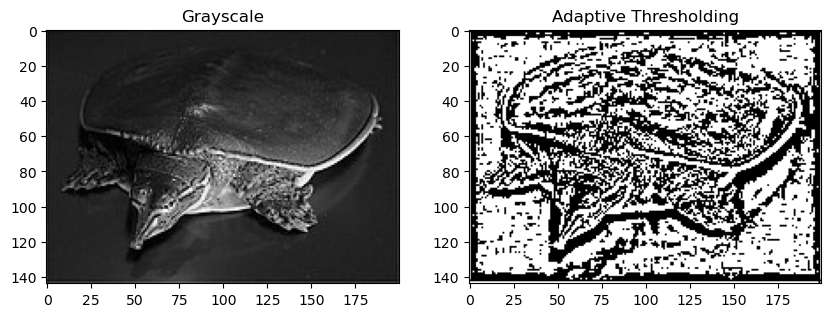

In [48]:
adaptive_threshold = cv2.adaptiveThreshold(
    gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
    cv2.THRESH_BINARY, 11, 2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale")

plt.subplot(1,2,2)
plt.imshow(adaptive_threshold, cmap='gray')
plt.title("Adaptive Thresholding")
plt.show()

## 6. Visualization Layout

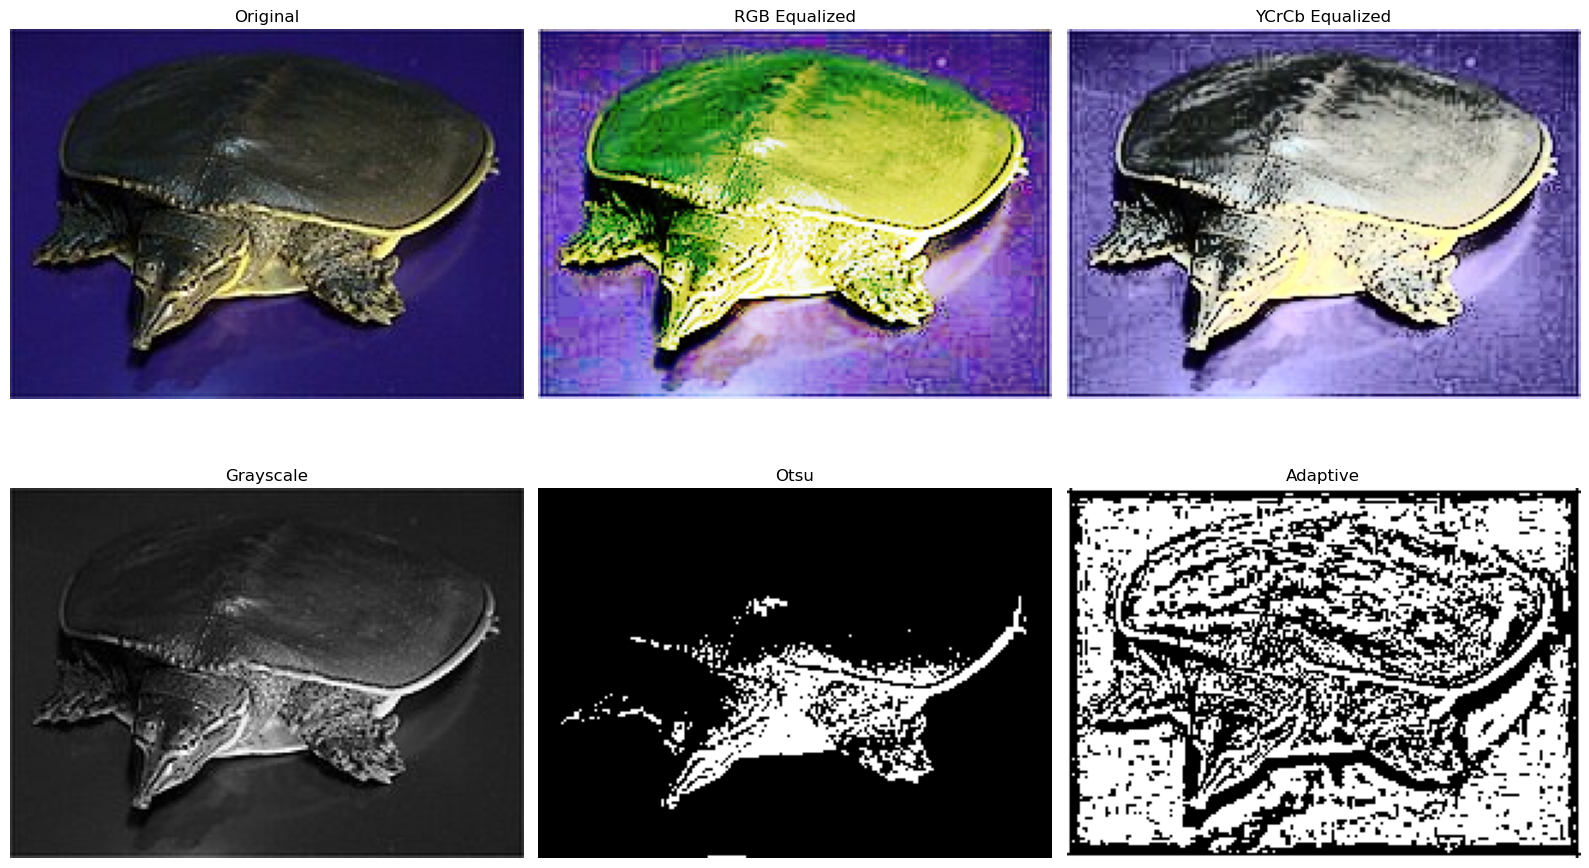

In [53]:
def comparison(images, titles, rows=2, cols=3):
    plt.figure(figsize=(16, 10))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

comparison(
    [image, equalize_rgb, equalize_ycrcb, gray_image, otsu_threshold, adaptive_threshold],
    ["Original", "RGB Equalized", "YCrCb Equalized", "Grayscale", "Otsu", "Adaptive"],
    rows=2, cols=3
)